In [1]:
import pickle
import pandas as pd
import spacy
import en_core_web_sm
import re, string
import nltk
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 1000)
pd.set_option("display.precision", 3)
from spacy.lang.en.stop_words import STOP_WORDS
from IPython.display import display
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics.pairwise import cosine_similarity

## Goal and Context

Online movie reviews influence a global audience, and are commonly used by consumer to decide if a movie is worth the price and time. They have become a crucial aspect of the movie industry. 

Our goal is to gain insights from IMDB online movie reviews to inform Pinewood Studio 2021 strategic planning. Specifically, we want to answer the following questions: a) What aspect of a movie people tend to consider relevant when writing a review? b)When people like or dislike a movie, what aspects of the movie do they  like or disklile?

## Loading in DataFrame

In [2]:
reviews = pd.read_csv('IMDB Dataset.csv')
reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


#### Creating a Random Sample

In [3]:
reviews_sample_25 = reviews.sample(n= 25000, random_state= 42, axis= 0)
df = reviews_sample_25[:]
df = df.reset_index(drop=True)

### Distribution of Reviews by Sentiment

In [4]:
df.sentiment.value_counts()

positive    12517
negative    12483
Name: sentiment, dtype: int64

<AxesSubplot:title={'center':'Frequency of Reviews by Sentiment'}>

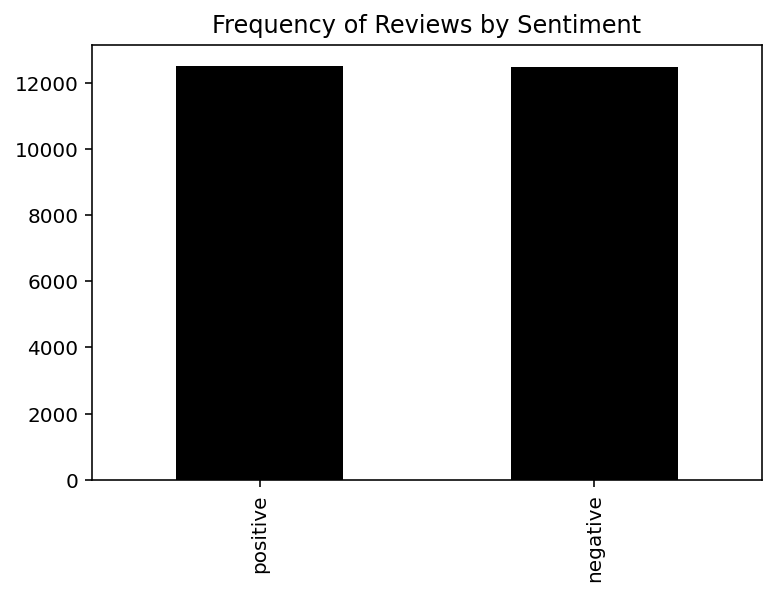

In [5]:
df.sentiment.value_counts().plot.bar(title="Frequency of Reviews by Sentiment", color = "black")

## Text Pre-processing

### Text Cleaning

In [6]:
html = lambda x: re.sub('<[^>]+>', '', x) 
backslashes = lambda x: x.replace('\\', '')
SpaceAfterDot = lambda x: re.sub(r'\.(?=[^ \W\d])', '. ', x)
punctuations = lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x)
numbers = lambda x : re.sub('\w*\d\w*', '', x)
lower = lambda x: x.lower()

In [7]:
df["clean"] = df["review"].map(html).map(backslashes).map(SpaceAfterDot).\
                map(punctuations).map(numbers).map(lower)
df.head()

,review,sentiment,clean
0,I really liked this Summerslam due to the look...,positive,i really liked this summerslam due to the look...
1,Not many television shows appeal to quite as m...,positive,not many television shows appeal to quite as m...
2,The film quickly gets to a major chase scene w...,negative,the film quickly gets to a major chase scene w...
3,Jane Austen would definitely approve of this o...,positive,jane austen would definitely approve of this o...
4,Expectations were somewhat high for me when I ...,negative,expectations were somewhat high for me when i ...


### Lemmatization

In [8]:
nlp = spacy.load("en", disable=["parser", "ner"])
spacy_lemmatize = lambda x: " ".join([token.lemma_ for token in nlp(x)])

In [9]:
df["Lemmatized"] = df["clean"].apply(spacy_lemmatize)
df.head()

,review,sentiment,clean,Lemmatized
0,I really liked this Summerslam due to the look...,positive,i really liked this summerslam due to the look...,i really like this summerslam due to the look ...
1,Not many television shows appeal to quite as m...,positive,not many television shows appeal to quite as m...,not many television show appeal to quite as ma...
2,The film quickly gets to a major chase scene w...,negative,the film quickly gets to a major chase scene w...,the film quickly get to a major chase scene wi...
3,Jane Austen would definitely approve of this o...,positive,jane austen would definitely approve of this o...,jane austen would definitely approve of this o...
4,Expectations were somewhat high for me when I ...,negative,expectations were somewhat high for me when i ...,expectation be somewhat high for -PRON- when i...


### Stop Words

#### Defining Stop-Words

In [10]:
nlp = spacy.load("en_core_web_sm")
nlp.Defaults.stop_words |= {'movie', 'film', 'basically', '-PRON-', 's', 'overall', 'vs',
                           "actually", "admit", "ago", "apart", "ask", "aside", "assume", "away",
                           "brother", "car", "cause", "channel", "chris", "cop", "sam", "robert",
                           "far", "hour", "way", "suppose", "want", "know", "mean", "hey", "hand",
                           "eye", "allow", "turn", "de", "david", "element", "jane", "jack", "paul",
                           "james", "sure", "probably", "later", "maybe", "steve", "tom", "try", "william",
                           "wind", "accept", "age", "air", "area", "attempt", "ben", "case", "check",
                           "city", "check", "class", "clear", "compare", "bar", "doctor", "scott", "serve",
                           "single", "sit", "situation", "somewhat", "station", "state", "achieve", "actual",
                           "blow", "bill", "sort", "speak", "sense", "include", "face", "seriously", "decide",
                           "personally", "exactly", "totally", "english", "minute", "leave", "early", "point",
                           "john", "return", "mr", "soon", "oh", "piece", "cost", "redeem", "completely", "let",
                           "ok", "possibly", "list", "half", "possible", "excuse", "obviously", "entire",
                           "come", "thing", "begin", "yes", "york", "wow", "yeah", "wish", "year", "kind",
                           "total", "comment", "example", "truly", "complete", "watch", "watching", "agree", 
                           "answer", "appear", "arm", "arrive", "aspect", "base", "billy", "bring", "center",
                           "central", "century", "certainly", "chance", "charles", "charlie", "room", "send",
                           "ship", "look", "okay", "etc", "stay", "imdb", "definitely", "fall", "stuff", "british",
                           "american", "job", "bit", "van", "simply", "wait", "find", "past", "ahead", "happen",
                           "talk", "review", "day", "person", "tell", "word", "use", "expect", "opinion", "especially",
                           "absolutely", "like", "think", "time", "feel", "tell", "viewer", "lot", "fan", "dr", "store",
                           "particularly", "type", "head", "plenty", "idea", "guy", "moment", "line", "gag", "right",
                           "right", "jim", "michael", "davis", "thoroughly", "view", "seat", "big", "little", "vote",
                            "version", "instead", "introduce", "event", "previous", "week", "add", "despite", "need",
                           "involve", "richard", "ms", "jones", "ray", "number", "lee", "old", "george", "richard", "group",
                           "ryan", "martin", "smith", "available", "choose", "certain", "pass", "form", "fit"}
my_stop_words = STOP_WORDS
print(my_stop_words)
type(my_stop_words)

{'thereby', 'their', 'single', 'him', 'such', 'no', 'everyone', 'instead', 'watch', 'review', 'chris', 'etc', 'eye', 'which', 'with', 'another', 'call', 'kind', 'together', 'somewhere', 'please', 'brother', 'find', 'part', 'anyway', 'but', 'its', 'attempt', 'british', 'bring', 'thoroughly', 'due', 'whenever', 'piece', 'who', 'it', 'above', 'doing', '‘m', 'forty', 'on', 'we', 'are', 'jim', 'bill', 'itself', 'store', 'billy', 'later', 'hereby', 'indeed', 'beside', 'rather', 'again', 'event', 'david', 'age', 'been', 'make', 'whatever', 'wait', 'her', 'certain', 'fall', 'jack', 'along', 'arrive', 'ship', '’re', 'anyone', 'agree', 'form', 'soon', 'fit', 'besides', 'just', 'among', 'often', 'from', 'per', 'smith', 'cannot', 'those', '‘d', 'how', 'charles', 'nor', 'they', 'obviously', 'really', 'wind', 'bar', 'some', 'serious', 'before', 'has', 'decide', 'toward', 'city', 'eight', 'only', 'yes', 'air', 'lot', 'his', 'becomes', 'sit', 'de', 'name', 'hers', 'ray', 'complete', 'me', 'thus', 'thr

set

#### Removing Stop-Words

In [11]:
NoStopWords = lambda x: " ".join(w for w in word_tokenize(x) if not w in my_stop_words)

In [12]:
df["NoStopWords"] = df["Lemmatized"].apply(NoStopWords)
df.head()

,review,sentiment,clean,Lemmatized,NoStopWords
0,I really liked this Summerslam due to the look...,positive,i really liked this summerslam due to the look...,i really like this summerslam due to the look ...,summerslam arena curtain interesting reason an...
1,Not many television shows appeal to quite as m...,positive,not many television shows appeal to quite as m...,not many television show appeal to quite as ma...,television appeal different farscape youngster...
2,The film quickly gets to a major chase scene w...,negative,the film quickly gets to a major chase scene w...,the film quickly get to a major chase scene wi...,quickly major chase scene increase destruction...
3,Jane Austen would definitely approve of this o...,positive,jane austen would definitely approve of this o...,jane austen would definitely approve of this o...,austen approve onegwyneth paltrow awesome capt...
4,Expectations were somewhat high for me when I ...,negative,expectations were somewhat high for me when i ...,expectation be somewhat high for -PRON- when i...,expectation high carell wrong great anchorman ...


## Vectorization

In [13]:
tfidf = TfidfVectorizer(max_features = 1000, min_df = 20)
doc_word_tfidf = tfidf.fit_transform(df["NoStopWords"])
pd.DataFrame(doc_word_tfidf.toarray(), columns = tfidf.get_feature_names())

,ability,able,absolute,accent,accident,act,acting,action,actor,actress,adaptation,adult,adventure,affair,agent,alien,alive,amazing,america,americans,amusing,angel,angle,angry,animal,animate,animation,annoying,anymore,apartment,apparently,appeal,appearance,appreciate,approach,army,art,artist,atmosphere,attack,attention,attitude,attractive,audience,average,avoid,award,awesome,awful,baby,background,bad,badly,ball,band,barely,basic,batman,battle,bear,beat,beautiful,beautifully,beauty,bed,beginning,believable,believe,bizarre,black,blame,blood,blue,board,boat,body,bond,book,bore,boring,boss,bother,box,boy,boyfriend,brain,break,brief,brilliant,bruce,buddy,budget,build,building,bunch,burn,business,buy,camera,camp,captain,capture,care,career,carry,cartoon,cast,cat,catch,challenge,change,character,charm,charming,chase,cheap,cheesy,chemistry,child,childhood,choice,christian,christmas,christopher,church,cinema,cinematic,cinematography,claim,classic,clearly,clever,climax,close,clothe,club,clue,cold,collection,college,color,combine,comedy,comic,commentary,commercial,commit,common,company,compelling,complex,computer,concept,concern,conclusion,conflict,consider,constantly,contain,content,continue,control,convince,convincing,cool,copy,costume,count,country,couple,course,cover,crap,crash,crazy,create,creative,creature,credit,creepy,crew,crime,criminal,critic,cross,cry,cult,culture,cut,cute,dad,damn,dance,dark,date,daughter,dead,deal,death,decade,decent,decision,deep,deeply,deliver,demon,depict,depth,describe,desert,deserve,design,desire,destroy,detail,detective,develop,development,dialog,dialogue,die,difference,different,difficult,direct,direction,director,dirty,disappoint,disappointed,disappointing,disappointment,disaster,discover,disney,display,documentary,dog,dollar,don,door,doubt,drag,drama,dramatic,draw,dream,dress,drink,drive,...,rock,role,roll,romance,romantic,ruin,rule,run,sad,sadly,save,scare,scary,scene,scenery,school,science,scientist,scifi,score,scream,screen,screenplay,script,sea,search,season,second,secret,seek,seemingly,self,sell,sequel,sequence,serial,series,set,setting,seven,sex,sexual,sexy,shame,share,shine,shock,shocking,shoot,short,shot,sick,sight,sign,silent,silly,similar,simple,sing,singer,sister,skill,skip,slasher,sleep,slightly,slow,slowly,small,smart,smile,social,society,soldier,solid,son,song,sorry,soul,sound,soundtrack,south,space,special,spend,spirit,spoil,spoiler,sport,spot,stage,stand,standard,star,start,steal,step,stereotype,stewart,stick,stone,stop,story,storyline,straight,strange,street,strike,strong,struggle,student,studio,study,stunning,stupid,style,subject,subtle,succeed,success,successful,suck,suddenly,suffer,suggest,suicide,suit,summer,super,superb,support,supposedly,surely,surprise,surprised,surprisingly,surround,survive,suspect,suspense,sweet,system,tale,talent,talented,tape,taste,teach,teacher,team,tear,teen,teenager,television,tend,tension,term,terrible,terrific,thank,theater,theatre,theme,thought,thrill,thriller,throw,tie,tired,title,today,tone,tony,torture,touch,touching,tough,town,track,tragedy,tragic,trailer,train,trap,trash,travel,treat,trip,trouble,true,trust,truth,tv,twice,twist,typical,ugly,ultimately,unbelievable,understand,unfortunately,unique,unlike,usual,usually,utterly,value,vampire,victim,video,villain,violence,violent,vision,visit,visual,voice,walk,wall,war,warn,waste,water,weak,weapon,wear,weird,west,western,whatsoever,white,wife,wild,win,window,witness,woman,wonder,wonderful,wood,work,world,worth,worthy,write,writer,writing,wrong,young,zombie
0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.000,0.00,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.259,0.0,0.0,0.0,0.121,0.0,0.0,0.0,0.000,0.000,0.0,0.000,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,

## Topic Modeling

### Non-Negative Matrix Factorization (NMF)

In [14]:
nmf = NMF(n_components=10, max_iter=2000)
doc_topic = nmf.fit_transform(doc_word_tfidf)

Adding the column "Primary Topic" to the document-topic matrix

In [15]:
doc_topic = pd.DataFrame(doc_topic).add_prefix('topic_')
doc_topic['Primary_Topic'] = doc_topic.idxmax(axis=1)

#### Document-Topic Matrix
Ddding the columns 'sentiment' and 'review' to the document-topic matrix

In [16]:
doc_topic_matrix= doc_topic
doc_topic_matrix[['sentiment', 'review']] = df[['sentiment', 'review']]
doc_topic_matrix.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,Primary_Topic,sentiment,review
0,0.011,0.012,1.479e-02,0.000,0.000,0.000,0.011,0.000,0.003,0.019,topic_9,positive,I really liked this Summerslam due to the look...
1,0.009,0.000,1.185e-02,0.001,0.000,0.070,0.042,0.001,0.000,0.022,topic_5,positive,Not many television shows appeal to quite as m...
2,0.035,0.032,2.727e-03,0.000,0.001,0.003,0.035,0.000,0.002,0.000,topic_6,negative,The film quickly gets to a major chase scene w...
3,0.000,0.000,2.317e-02,0.028,0.003,0.000,0.000,0.007,0.002,0.019,topic_3,positive,Jane Austen would definitely approve of this o...
4,0.009,0.006,5.841e-04,0.014,0.006,0.003,0.000,0.006,0.002,0.049,topic_9,negative,Expectations were somewhat high for me when I ...


#### Word-Topic Matrix

In [17]:
word_topic_matrix= pd.DataFrame(nmf.components_.round(3),
             index = ["Horror","Bad Movie","Good Movie", "Comedy", "Romance", "Tv Show", "Character/Plot", 
                      "Acting Performance", "Book Adaptation", "Drama"],
             columns = tfidf.get_feature_names()).T
word_topic_matrix.head()

,Horror,Bad Movie,Good Movie,Comedy,Romance,Tv Show,Character/Plot,Acting Performance,Book Adaptation,Drama
ability,0.034,0.005,0.000,0.018,0.000,0.000,0.048,0.052,0.000,0.058
able,0.070,0.038,0.005,0.012,0.014,0.023,0.036,0.086,0.022,0.145
absolute,0.050,0.047,0.000,0.024,0.000,0.015,0.010,0.014,0.012,0.015
accent,0.032,0.050,0.014,0.000,0.000,0.000,0.053,0.082,0.035,0.032
accident,0.046,0.002,0.000,0.000,0.008,0.016,0.000,0.000,0.000,0.075


## Topic Interpretation

### Main Words by Topic

In [18]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [19]:
display_topics(nmf, tfidf.get_feature_names(), 50)


Topic  0
scene, horror, plot, action, effect, kill, end, budget, killer, pretty, gore, shoot, flick, fight, low, original, director, sound, special, start, monster, blood, scary, video, dead, sequence, shot, cut, night, death, camera, zombie, set, genre, house, sex, work, murder, run, long, cheap, feature, music, dvd, fun, star, slasher, boring, girl, reason

Topic  1
bad, waste, acting, awful, terrible, horrible, script, actor, act, money, plot, stupid, people, crap, believe, effect, write, suck, poor, rent, avoid, special, low, reason, save, garbage, ridiculous, pathetic, laugh, trash, god, end, boring, dialogue, cheap, writing, kid, sorry, quality, start, budget, wrong, director, pay, lame, direction, badly, hope, hate, guess

Topic  2
good, pretty, acting, action, enjoy, recommend, nice, fun, people, excellent, worth, story, end, flick, interesting, cool, win, ending, friend, rating, decent, oscar, actor, guess, entertaining, cast, twist, actress, special, happy, plot, hard, hate,

### Naming the Topics

In [20]:
'''
Topic 0: Horror
Topic 1: Bad Movie
Topic 2: Good Movie
Topic 3: Comedy
Topic 4: Romance
Topic 5: Tv Show (scifi, aliens, animated)
Topic 6: Characters, plot
Topic 7: Acting/Performance
Topic 8: Book adaptation
Topic 9: Drama
'''

'\nTopic 0: Horror\nTopic 1: Bad Movie\nTopic 2: Good Movie\nTopic 3: Comedy\nTopic 4: Romance\nTopic 5: Tv Show (scifi, aliens, animated)\nTopic 6: Characters, plot\nTopic 7: Acting/Performance\nTopic 8: Book adaptation\nTopic 9: Drama\n'

### Word-Topic Matrix Sorted by Topic

#### Topic 0: Horror

In [21]:
word_topic_matrix.sort_values(by='Horror', ascending=False).head(8)

,Horror,Bad Movie,Good Movie,Comedy,Romance,Tv Show,Character/Plot,Acting Performance,Book Adaptation,Drama
scene,2.467,0.000,0.000,0.036,0.197,0.000,0.000,0.00,0.000,0.000
horror,1.506,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000
plot,0.901,0.316,0.066,0.029,0.000,0.050,0.429,0.00,0.014,0.000
action,0.786,0.000,0.237,0.000,0.000,0.016,0.097,0.01,0.000,0.000
effect,0.705,0.204,0.039,0.000,0.000,0.055,0.000,0.00,0.002,0.000
kill,0.611,0.065,0.000,0.000,0.000,0.004,0.000,0.00,0.000,0.266
end,0.557,0.119,0.120,0.007,0.125,0.119,0.364,0.00,0.000,0.336
budget,0.556,0.108,0.033,0.000,0.000,0.000,0.000,0.00,0.000,0.000


####  Topic 1: Bad Movie

In [22]:
word_topic_matrix.sort_values(by='Bad Movie', ascending=False).head(8)

,Horror,Bad Movie,Good Movie,Comedy,Romance,Tv Show,Character/Plot,Acting Performance,Book Adaptation,Drama
bad,0.000,3.410,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
waste,0.102,0.528,0.000,0.083,0.000,0.000,0.100,0.000,0.048,0.022
acting,0.235,0.525,0.296,0.000,0.000,0.000,0.174,0.137,0.000,0.000
awful,0.167,0.415,0.000,0.076,0.000,0.007,0.036,0.000,0.018,0.000
terrible,0.241,0.404,0.000,0.029,0.004,0.000,0.000,0.000,0.045,0.000
horrible,0.088,0.370,0.003,0.050,0.000,0.012,0.013,0.000,0.036,0.000
script,0.150,0.359,0.000,0.062,0.000,0.000,0.137,0.359,0.037,0.000
actor,0.000,0.352,0.077,0.000,0.000,0.000,0.168,1.352,0.000,0.000


#### Topic 2: Good Movie

In [23]:
word_topic_matrix.sort_values(by='Good Movie', ascending=False).head(8)

,Horror,Bad Movie,Good Movie,Comedy,Romance,Tv Show,Character/Plot,Acting Performance,Book Adaptation,Drama
good,0.000,0.000,3.765,0.000,0.000,0.000,0.000,0.000,0.000,0.000
pretty,0.530,0.068,0.494,0.046,0.000,0.032,0.000,0.000,0.000,0.000
acting,0.235,0.525,0.296,0.000,0.000,0.000,0.174,0.137,0.000,0.000
action,0.786,0.000,0.237,0.000,0.000,0.016,0.097,0.010,0.000,0.000
enjoy,0.118,0.000,0.214,0.218,0.289,0.066,0.040,0.205,0.094,0.038
recommend,0.112,0.000,0.210,0.110,0.117,0.016,0.065,0.174,0.080,0.024
nice,0.159,0.006,0.205,0.023,0.059,0.010,0.074,0.082,0.000,0.076
fun,0.273,0.000,0.193,0.342,0.090,0.020,0.000,0.169,0.000,0.000


#### Topic 3: Comedy

In [24]:
word_topic_matrix.sort_values(by='Comedy', ascending=False).head(8)

,Horror,Bad Movie,Good Movie,Comedy,Romance,Tv Show,Character/Plot,Acting Performance,Book Adaptation,Drama
funny,0.000,0.000,0.000,2.589,0.000,0.000,0.000,0.000,0.000,0.000
comedy,0.000,0.000,0.000,1.794,0.000,0.000,0.000,0.131,0.000,0.000
laugh,0.035,0.122,0.002,1.440,0.000,0.000,0.000,0.000,0.000,0.000
joke,0.000,0.095,0.000,0.825,0.000,0.045,0.000,0.000,0.012,0.000
humor,0.017,0.000,0.014,0.526,0.038,0.024,0.047,0.003,0.008,0.041
hilarious,0.035,0.000,0.000,0.426,0.071,0.021,0.000,0.092,0.000,0.000
fun,0.273,0.000,0.193,0.342,0.090,0.020,0.000,0.169,0.000,0.000
stupid,0.195,0.289,0.000,0.259,0.000,0.006,0.017,0.000,0.000,0.011


#### Topic 4: Romance

In [25]:
word_topic_matrix.sort_values(by='Romance', ascending=False).head(8)

,Horror,Bad Movie,Good Movie,Comedy,Romance,Tv Show,Character/Plot,Acting Performance,Book Adaptation,Drama
love,0.000,0.000,0.000,0.000,3.688,0.000,0.000,0.000,0.000,0.000
story,0.000,0.000,0.123,0.000,0.412,0.000,2.093,0.000,0.112,0.000
song,0.044,0.010,0.055,0.006,0.411,0.000,0.000,0.285,0.000,0.000
music,0.282,0.008,0.033,0.000,0.385,0.000,0.000,0.457,0.000,0.000
kid,0.134,0.110,0.015,0.242,0.374,0.031,0.000,0.000,0.036,0.221
girl,0.264,0.062,0.059,0.054,0.337,0.000,0.000,0.000,0.000,0.378
enjoy,0.118,0.000,0.214,0.218,0.289,0.066,0.040,0.205,0.094,0.038
beautiful,0.020,0.000,0.000,0.000,0.275,0.000,0.092,0.174,0.011,0.204


#### Topic 5: Tv Show

In [26]:
word_topic_matrix.sort_values(by='Tv Show', ascending=False).head(8)

,Horror,Bad Movie,Good Movie,Comedy,Romance,Tv Show,Character/Plot,Acting Performance,Book Adaptation,Drama
episode,0.000,0.000,0.000,0.000,0.000,2.225,0.000,0.000,0.000,0.000
series,0.000,0.000,0.000,0.000,0.000,2.081,0.000,0.000,0.019,0.000
tv,0.000,0.093,0.026,0.089,0.025,0.837,0.000,0.139,0.064,0.067
season,0.000,0.000,0.000,0.000,0.020,0.711,0.000,0.000,0.000,0.000
new,0.211,0.000,0.000,0.032,0.102,0.312,0.038,0.098,0.000,0.393
original,0.442,0.028,0.000,0.050,0.000,0.296,0.156,0.112,0.147,0.000
television,0.000,0.019,0.000,0.028,0.000,0.280,0.000,0.072,0.014,0.080
dvd,0.280,0.024,0.000,0.027,0.139,0.209,0.000,0.258,0.094,0.000


#### Topic 6: Character/Plot

In [27]:
word_topic_matrix.sort_values(by='Character/Plot', ascending=False).head(8)

,Horror,Bad Movie,Good Movie,Comedy,Romance,Tv Show,Character/Plot,Acting Performance,Book Adaptation,Drama
character,0.000,0.000,0.000,0.089,0.000,0.019,2.735,0.0,0.000,0.000
story,0.000,0.000,0.123,0.000,0.412,0.000,2.093,0.0,0.112,0.000
main,0.103,0.024,0.017,0.026,0.000,0.000,0.523,0.0,0.003,0.016
interesting,0.251,0.000,0.097,0.000,0.000,0.071,0.457,0.0,0.000,0.066
plot,0.901,0.316,0.066,0.029,0.000,0.050,0.429,0.0,0.014,0.000
end,0.557,0.119,0.120,0.007,0.125,0.119,0.364,0.0,0.000,0.336
care,0.096,0.058,0.000,0.000,0.039,0.000,0.278,0.0,0.000,0.124
development,0.031,0.002,0.000,0.000,0.000,0.000,0.274,0.0,0.000,0.000


#### Topic 7: Acting Performance

In [28]:
word_topic_matrix.sort_values(by='Acting Performance', ascending=False).head(8)

,Horror,Bad Movie,Good Movie,Comedy,Romance,Tv Show,Character/Plot,Acting Performance,Book Adaptation,Drama
great,0.000,0.000,0.000,0.000,0.094,0.000,0.000,2.817,0.000,0.000
play,0.000,0.000,0.000,0.000,0.000,0.000,0.105,1.543,0.000,0.344
actor,0.000,0.352,0.077,0.000,0.000,0.000,0.168,1.352,0.000,0.000
performance,0.000,0.000,0.048,0.000,0.000,0.000,0.112,1.203,0.000,0.044
role,0.000,0.000,0.024,0.000,0.000,0.000,0.075,1.161,0.000,0.081
cast,0.052,0.048,0.069,0.058,0.000,0.075,0.060,0.895,0.022,0.004
excellent,0.000,0.000,0.131,0.000,0.000,0.057,0.032,0.535,0.026,0.043
work,0.328,0.021,0.012,0.075,0.000,0.028,0.157,0.479,0.084,0.402


#### Topic 8: Book Adaptation

In [29]:
word_topic_matrix.sort_values(by='Book Adaptation', ascending=False).head(8)

,Horror,Bad Movie,Good Movie,Comedy,Romance,Tv Show,Character/Plot,Acting Performance,Book Adaptation,Drama
book,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.678,0.000
read,0.035,0.064,0.006,0.031,0.003,0.000,0.029,0.014,1.126,0.089
novel,0.000,0.000,0.000,0.000,0.000,0.000,0.069,0.075,0.532,0.026
adaptation,0.000,0.000,0.000,0.000,0.000,0.000,0.040,0.059,0.309,0.000
write,0.045,0.204,0.000,0.057,0.007,0.064,0.125,0.173,0.215,0.165
change,0.025,0.001,0.020,0.007,0.022,0.053,0.107,0.000,0.172,0.252
original,0.442,0.028,0.000,0.050,0.000,0.296,0.156,0.112,0.147,0.000
understand,0.057,0.049,0.003,0.054,0.029,0.000,0.134,0.000,0.120,0.226


#### Topic 9: Drama

In [30]:
word_topic_matrix.sort_values(by='Drama', ascending=False).head(8)

,Horror,Bad Movie,Good Movie,Comedy,Romance,Tv Show,Character/Plot,Acting Performance,Book Adaptation,Drama
life,0.000,0.000,0.000,0.000,0.059,0.000,0.000,0.000,0.000,1.444
man,0.007,0.000,0.000,0.025,0.000,0.000,0.000,0.045,0.000,1.270
people,0.000,0.278,0.157,0.184,0.000,0.000,0.000,0.000,0.055,1.165
woman,0.060,0.000,0.000,0.000,0.024,0.000,0.000,0.000,0.000,0.913
young,0.000,0.000,0.000,0.000,0.097,0.000,0.000,0.170,0.000,0.741
world,0.000,0.000,0.000,0.000,0.007,0.065,0.000,0.041,0.035,0.716
family,0.000,0.000,0.000,0.044,0.173,0.038,0.000,0.000,0.000,0.644
live,0.000,0.000,0.008,0.000,0.062,0.047,0.009,0.000,0.000,0.623


### Samples of Reviews by Topic

#### Topic 0: Horror

In [82]:
for r in doc_topic_matrix.sort_values(by='topic_0', ascending=False).head(3)['review'].values:
    print(r)
    print()

Tacky, but mildly entertaining early 90's soft core comedy features Xena (Sarah Bellemo), Luna (Tamara Landry), and Sola (Nicole Posey), as three outer-space teenagers. Xena's parents have gone on vacation for a couple of days. Following some persistent persuasion from her friends, Xena agrees to take her father's spaceship for a ride. The end result? They wind up running out of gas in space, and crash-land on planet Beta 45, AKA earth. Meanwhile, teenagers Dave (Michael Todd Davis) and Jerry (Ken Steadman) have come to California to stay the summer with Dave's Uncle Bud (Joe Estevez ) a beach bum who lives right on the beach. The three of them wind up meeting our three space girls who have walked away from the crash without a scratch. Uncle Bud is about to be thrown out from his soon-to-be-condemned beach pad thanks to Sally (Linnea Quigley), who lives right up the hill and used to be in a relationship with Bud. She's also a bikini magnate, and is trying to win a bikini design contest

#### Topic 1: Bad Movie

In [83]:
for r in doc_topic_matrix.sort_values(by='topic_1', ascending=False).head(2)['review'].values:
    print(r)
    print()

This movie is so bad, I knew how it ends right after this little girl killed the first person. Very bad acting very bad plot very bad movie<br /><br />do yourself a favour and DON'T watch it 1/10

This movie is bad. I don't just mean 'bad' as in; "Oh the script was bad", or; "The acting in that scene was bad".....I mean bad as in someone should be held criminally accountable for foisting this unmitigated pile of steaming crud onto an unsuspecting public. I won't even dignify it with an explanation of the (Plot??) if I can refer to it as that.I can think of only one other occasion in some 40-odd years of movie watching that I have found need to vent my spleen on a movie. I mean, after all, no one goes out to intentionally make a bad movie, do they? Well, yes. Apparently they do...and the guilty man is writer/director Ulli Lommel. But the worst of it is that Blockbusters is actually renting this to their customers! Be advised. Leave this crap where it belongs. Stuck on the shelf, gatheri

#### Topic 2: Good Movie

In [86]:
for r in doc_topic_matrix.sort_values(by='topic_2', ascending=False).head(4)['review'].values:
    print(r)
    print()

This is a good film. This is very funny. Yet after this film there were no good Ernest films!

I don't get this. The movie obviously has a pretty good budget. It has very good cinematography. It has nice pacing, good editing and pretty good directing too. Then WHY OH WHY didn't they hire someone to do a final rewrite of the script so it would not be so damn cheesy and WHY OH WHY did they hire such lousy actors that can't act their way out of a paper bag? This movie could have been good. At most times it LOOKS good and FEELS good but in the end, you realize that the movie was no good at all.<br /><br />So I would say it's a good production but a bad movie. Too bad actually.<br /><br />And eels? Come one, really!

First off let me say, If you haven't enjoyed a Van Damme movie since bloodsport, you probably will not like this movie. Most of these movies may not have the best plots or best actors but I enjoy these kinds of movies for what they are. This movie is much better than any of the

#### Topic 3: Comedy

In [88]:
for r in doc_topic_matrix.sort_values(by='topic_3', ascending=False).head(3)['review'].values:
    print(r)
    print()

I've been going through the AFI's list of the top 100 comedies, and I must say that this is truly one of the worst. Not just of the 90 movies on the list I've seen, but of any movie I've ever seen. Drunks are funny sometimes, Dudley isn't. Liza almost made it worthwhile, but alas... just go watch Arrested Development if you want to see her in something good. Seriously, Dudley laughing and drinking is supposed to be funny? I would highly recommend almost ANY other movie on the AFI's top 100 comedies for more laughs than this. If you want to see a funnier "drunk", try The Thin Man. Funnier movie in general, any Marx Brothers movie will kill (especially if you're as drunk as Arthur).

I'm not sure what. I just couldn't laugh at it. I had an open mind. I didn't want to be a tight-@ss about it. But I seriously just couldn't laugh at this film. It was just not funny to me. Some parts it seemed like Ben Stiller and Jack Black tried too hard. Just because you put two very funny men together do

#### Topic 4: Romance

In [89]:
for r in doc_topic_matrix.sort_values(by='topic_4', ascending=False).head(3)['review'].values:
    print(r)
    print()

OK, so I loved Rachael Ray before, but now, I ADORE her! How innovative. I love that she has a cooking section- I admit that occasionally I skip that part, only because it makes me WAAAY too hungry! But I also love that you can get the next day's grocery list on her website. I love that she has regular helpers and that she's made some of her viewers become her regulars. I love how personable she is and how creative she is. I also like how she does her Mystery Guests. She just seems so much more genuine than so many other talk show hosts. She still gets a little starstruck occasionally and I love that. I love that she talks about her personal life on there and reminds people how happy she is. She's even mentioned tabloids before and it's so funny! She also has the funniest stories! Anyway, I'm a fan for life. Even my 2 year old knows who Rachael Ray is and he loves her too!

I must say as a girl with a cowboy of my own,I love this flick.It left me lovin them boots and wranglers even mor

#### Topic 5: Tv Show

In [90]:
for r in doc_topic_matrix.sort_values(by='topic_5', ascending=False).head(3)['review'].values:
    print(r)
    print()

I got this as a complete set of 9 episodes on 5 DVDs. I knew nothing about the history of the series. Season 1 of the series has the pilot episode as episode 1 and then 3 more episodes for a total of 4. Season 2 lists 5 episodes with the last being Beyond Good and Evil with an original Air Date of 7 December 1998. The other 4 episodes on season 2 were broadcast from December 1997 to Febrausry 1998. So Beyond Good and Evil looks like season 3 episode 1, except there are no more episodes in season 3.<br /><br />Spoilers here. The two main characters of the first 8 episodes, Dr. Iain McCallum (John Hannah) and Dr. Angela Moloney (Zara Turner), are missing from this episode being replaced by Dr. Dan Gallagher (Nathaniel Parker) and Dr. Charley Fielding (Eva Pope). I recognized Nathaniel Parker from the series The Inspector Lynley Mysteries, which began in 2001. So they were planning to have a season 3 but only one episode was broadcast.<br /><br />It seems odd to try to continue a series n

#### Topic 6: Character, Plot

In [91]:
for r in doc_topic_matrix.sort_values(by='topic_6', ascending=False).head(3)['review'].values:
    print(r)
    print()

Labeling this film a "lesbian love story" is about as accurate as calling Pride & Prejudice a "straight love story." There's just so much more to it than that.<br /><br />Yes, the main character is a lesbian, but her story is classic bildungsroman, a journey from childhood to adulthood, from sexual innocence into maturity, from personal blindness to self- discovery. There is a stylistic element of camp to the film's direction, but it is not a hindrance; rather it serves to underscore the staged and dramatic parts of the main character's life.<br /><br />Those who know Anna Chancellor from the BBC version of Pride and Prejudice will certainly be amazed with her here. Rachael Stirling is stellar as the main character Nan, and Keeley Hawes is all wide-eyed goodness as her lover Kitty Butler. Chancellor might have the stand out role, that is aside from Sally Hawkins who plays Zena Butler. This film is not for the faint of heart, but it's not a piece of pro-gay advertising either. It's a re

#### Topic 7: Acting Performance

In [93]:
for r in doc_topic_matrix.sort_values(by='topic_7', ascending=False).head(4)['review'].values:
    print(r)
    print()

Great movie about a great man. Thomas Kretschmann is first rate as in all of his other movies.I would never have envisioned him as Pope John Paul. It speaks volumes for the casting director. Why do they keep casting him as German officer in the movies? And he only came to universal attention after "the pianist"? Of course he looks so hot in the uniforms. I know a lot of girls drool over his handsome face. But this guy is a great actor and has such great potentials. If you don't believe me, go watch "Stalingrad". I hope he will get a lot of excellent roles in the future with more diversity. Otherwise, what a heartbreaking waste of great talent.

When this movie came out, I had seen Geena Davis play only soft, feminine roles... This movie was anything but soft and feminine. Great lines, great action...she and Samuel L really clicked. Too violent for the kiddies, but if you and your significant other are trying to agree on a movie, try this one on for size. Go Geena! Go Geena!

A DOUBLE L

#### Topic 8: Book adaptation

In [94]:
for r in doc_topic_matrix.sort_values(by='topic_8', ascending=False).head(3)['review'].values:
    print(r)
    print()

The movie 'Heart of Darkness', based on the 1899 book by Joseph Conrad is one with little to no detail and has an almost schizophrenic like plot line. If you have read the book then you know that little to none of the important "story making" scenes were put into the movie. In the book there is so much that is left up to the imagination and I feel that that is one of the part that make the book what is it. An example would be when Marlow spent timeless hours and days, even months waiting for rivets and that entire scene was left out of the movie. Again if you have read the book then you would know that this scene in the book is one that almost describes the main, theme of futility, best. Finally I feel that the movie was too cut and dry. Not enough though was put in to the original text and how that made the story what it is today.<br /><br />If you have not read the book, 'Heart of Darkness' (preferably, the Norton Critical Edition) then don't waist your time in renting or buying the 

#### Topic 9: Drama

In [96]:
for r in doc_topic_matrix.sort_values(by='topic_9', ascending=False).head(3)['review'].values:
    print(r)
    print()

Alejandro Amenabar, the young and talented Spanish director, clearly shows us he is a serious film maker. Anyone doubting it, should have a look at his latest film "The Sea Inside". This is a movie that has been rewarded with numerous accolades, not only in Spain, but throughout the world, wherever this wonderful movie has been shown.<br /><br />If you have not seen the film, perhaps you would like to stop here.<br /><br />Ramon Sampedro is a man confined to bed. Being quadriplegic, he depends on the kindness of strangers for everything. Since his accident, Ramon only thinks in one thing alone: how to end his life! This is the moral issue at the center of the story, based on the real Ramon Sampedro's life.<br /><br />Mr. Amenabar tells the story from Ramon's point of view. There is nothing here that is false or manipulative on his part. After all, he relies on facts that were well known in his country as this case became a "cause celebre" in favor of euthanasia, a theme that no one in 

## Proportion of Reviews by Primary Topic

In [38]:
doc_topic_matrix_df = doc_topic_matrix_df.rename(columns={'Primary Topic': 'Primary_Topic'})

(-1.0, 10.0, 0.0, 30.0)

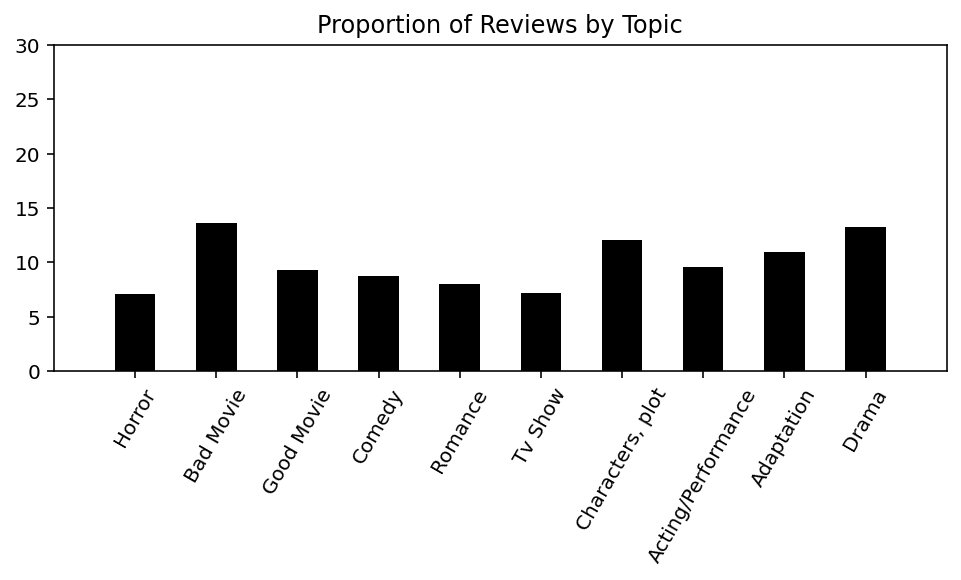

In [39]:
import numpy as np
labels = [
    'Horror',
    'Bad Movie',
    'Good Movie',
    'Comedy',
    'Romance',
    'Tv Show',
    'Characters, plot',
    'Acting/Performance',
    'Adaptation',
    'Drama']


plt.figure(figsize = (8,3))
valueCounts = doc_topic_matrix_df.Primary_Topic.value_counts(normalize = True).sort_index()*100
bar = valueCounts.plot.bar(title="Proportion of Reviews by Topic", color = 'black')
plt.xticks(ticks=np.arange(10), labels=labels, rotation = 60)
plt.axis([-1, 10, 0, 30])

## Positive Reviews by Primary Topic

In [43]:
positiveDocTopic = doc_topic_matrix_df.loc[doc_topic_matrix_df['sentiment'] == "positive"]

(-1.0, 10.0, 0.0, 30.0)

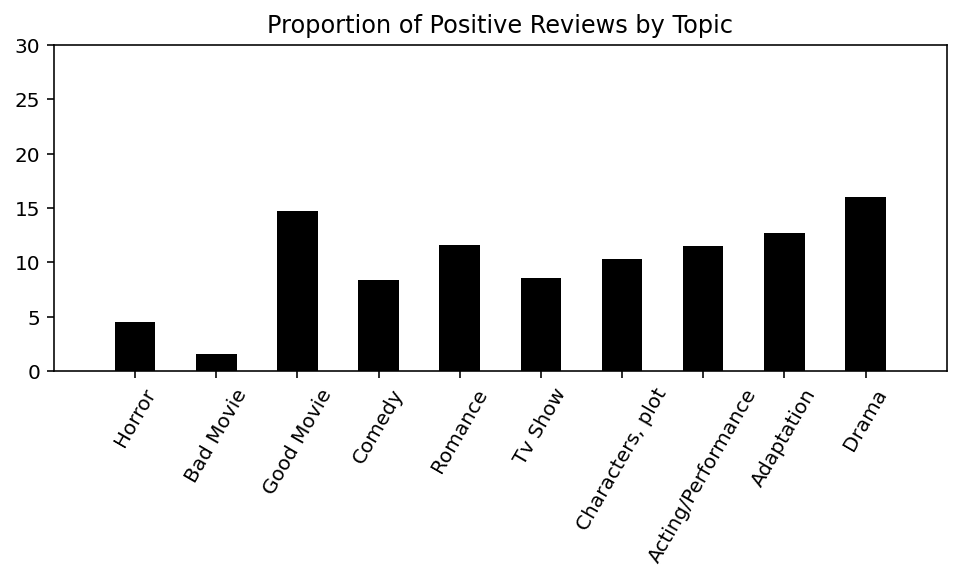

In [44]:
import numpy as np
labels = [
    'Horror',
    'Bad Movie',
    'Good Movie',
    'Comedy',
    'Romance',
    'Tv Show',
    'Characters, plot',
    'Acting/Performance',
    'Adaptation',
    'Drama']


plt.figure(figsize = (8,3))
valueCounts = positiveDocTopic.Primary_Topic.value_counts(normalize = True).sort_index()*100
bar = valueCounts.plot.bar(title="Proportion of Positive Reviews by Topic", color = 'black')
plt.xticks(ticks=np.arange(10), labels=labels, rotation = 60)
plt.axis([-1, 10, 0, 30])

## Negative Reviews by Primary Topic

In [45]:
negativeDocTopic = doc_topic_matrix_df.loc[doc_topic_matrix_df['sentiment'] == "negative"]

(-1.0, 10.0, 0.0, 30.0)

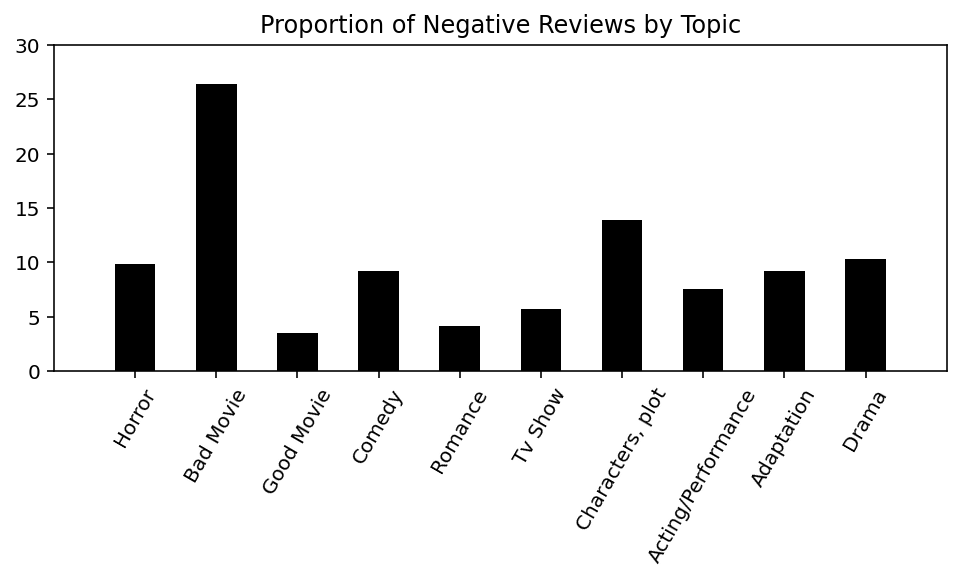

In [46]:
import numpy as np
labels = [
    'Horror',
    'Bad Movie',
    'Good Movie',
    'Comedy',
    'Romance',
    'Tv Show',
    'Characters, plot',
    'Acting/Performance',
    'Adaptation',
    'Drama']


plt.figure(figsize = (8,3))
valueCounts = negativeDocTopic.Primary_Topic.value_counts(normalize = True).sort_index()*100
bar = valueCounts.plot.bar(title="Proportion of Negative Reviews by Topic", color = 'black')
plt.xticks(ticks=np.arange(10), labels=labels, rotation = 60)
plt.axis([-1, 10, 0, 30])

### Average of Primary Topic Expression by Sentiment

In [ ]:
'''
Topic 0: Horror
Topic 1: Bad Movie
Topic 2: Good Movie
Topic 3: Comedy
Topic 4: Romance
Topic 5: Tv Show (scifi, aliens, animated)
Topic 6: Characters, plot
Topic 7: Acting Performance
Topic 8: Book adaptation
Topic 9: Drama
'''

<AxesSubplot:title={'center':'topic_0'}, xlabel='sentiment'>

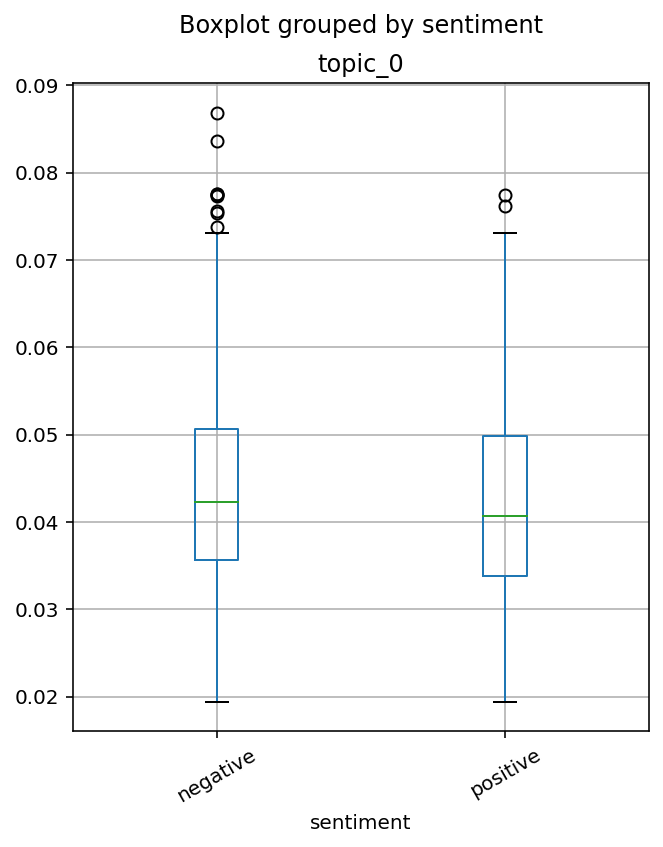

In [80]:
topic_0_viz = doc_topic_matrix_df.loc[doc_topic_matrix['Primary_Topic'] == 'topic_0']
topic_0_viz.boxplot('topic_0','sentiment',rot = 30,figsize=(5,6))

<AxesSubplot:title={'center':'topic_1'}, xlabel='sentiment'>

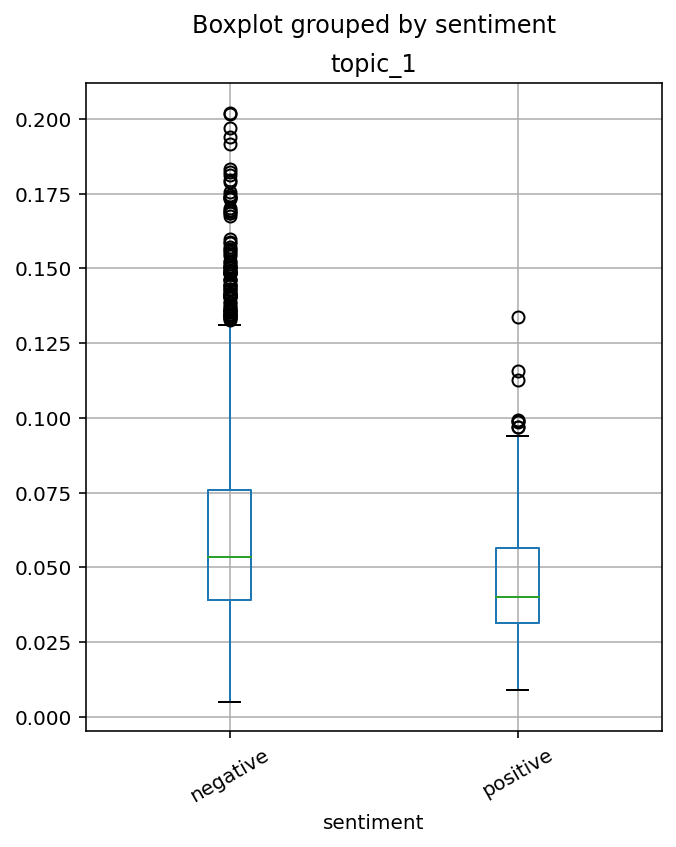

In [79]:
topic_1_viz = doc_topic_matrix.loc[doc_topic_matrix['Primary_Topic'] == 'topic_1']
topic_1_viz.boxplot('topic_1','sentiment',rot = 30,figsize=(5,6))

<AxesSubplot:title={'center':'topic_2'}, xlabel='sentiment'>

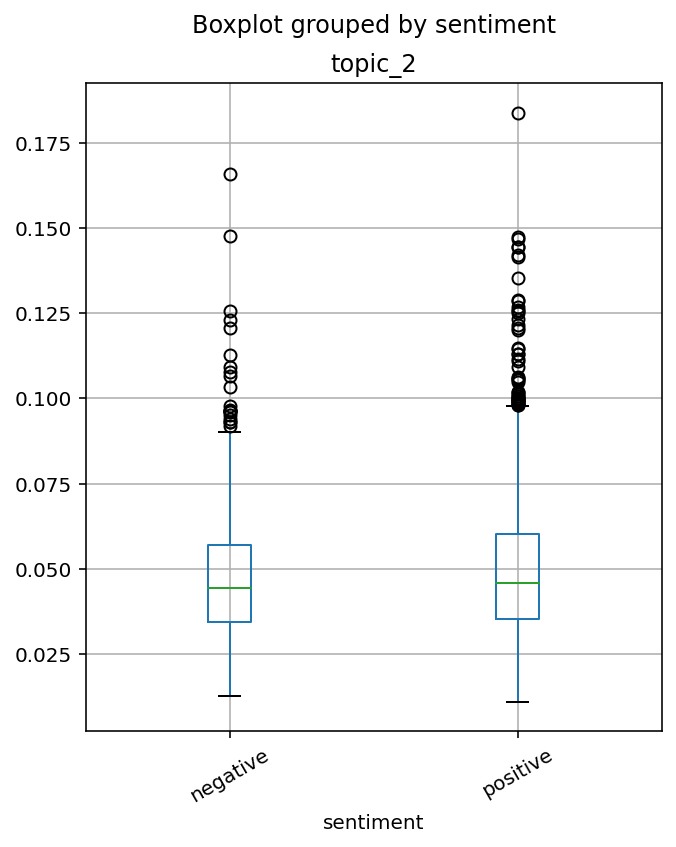

In [78]:
topic_2_viz = doc_topic_matrix.loc[doc_topic_matrix['Primary_Topic'] == 'topic_2']
topic_2_viz.boxplot('topic_2','sentiment',rot = 30,figsize=(5,6))

<AxesSubplot:title={'center':'topic_3'}, xlabel='sentiment'>

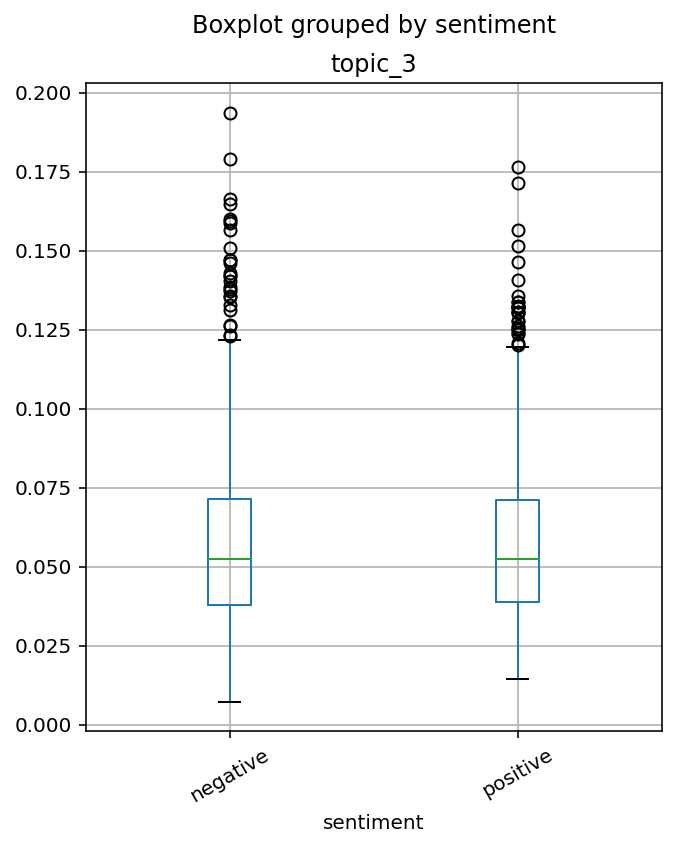

In [77]:
topic_3_viz = doc_topic_matrix.loc[doc_topic_matrix['Primary_Topic'] == 'topic_3']
topic_3_viz.boxplot('topic_3','sentiment',rot = 30,figsize=(5,6))

<AxesSubplot:title={'center':'topic_4'}, xlabel='sentiment'>

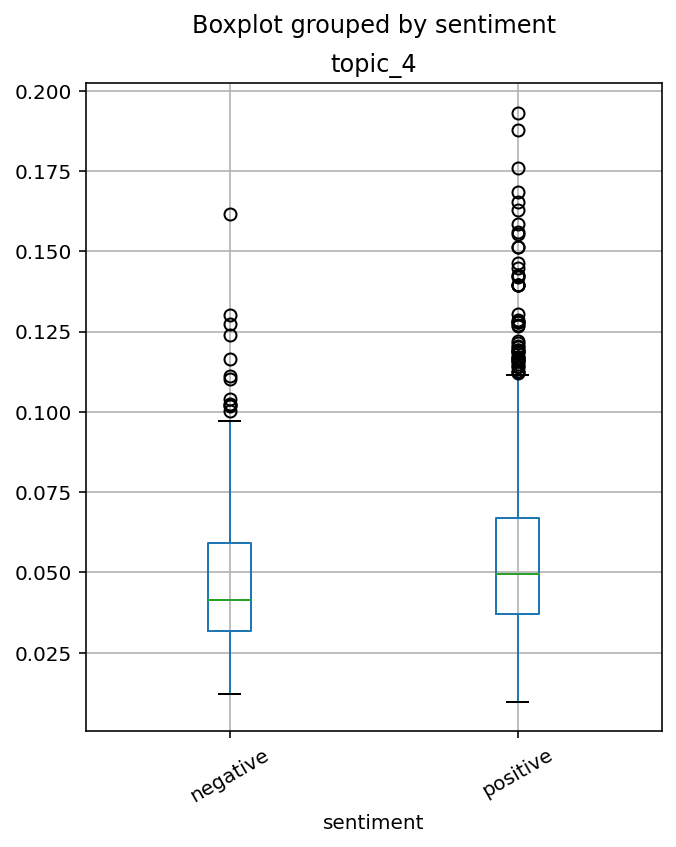

In [76]:
topic_4_viz = doc_topic_matrix.loc[doc_topic_matrix['Primary_Topic'] == 'topic_4']
topic_4_viz.boxplot('topic_4','sentiment',rot = 30,figsize=(5,6))

<AxesSubplot:title={'center':'topic_5'}, xlabel='sentiment'>

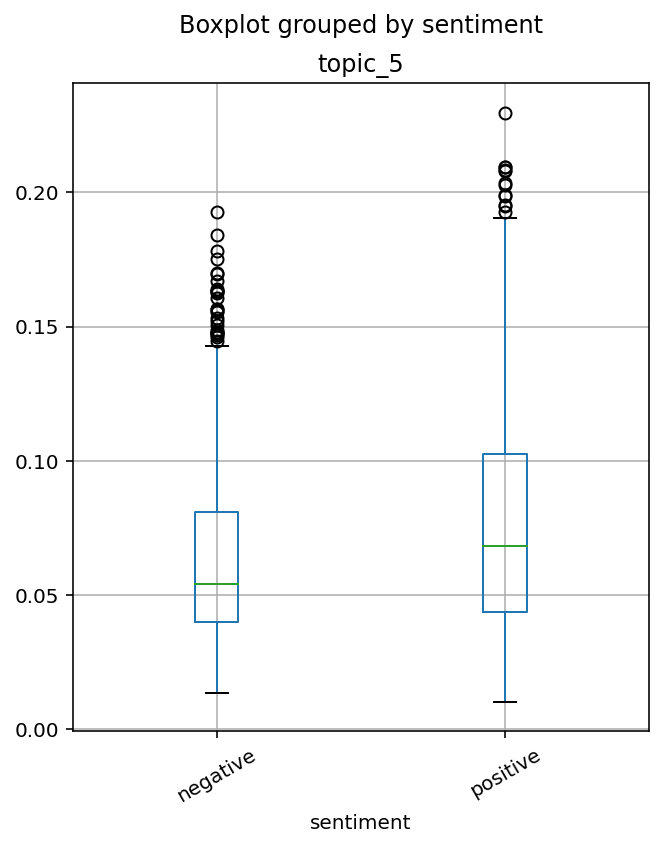

In [75]:
topic_5_viz = doc_topic_matrix.loc[doc_topic_matrix['Primary_Topic'] == 'topic_5']
topic_5_viz.boxplot('topic_5','sentiment',rot = 30,figsize=(5,6))

<AxesSubplot:title={'center':'topic_6'}, xlabel='sentiment'>

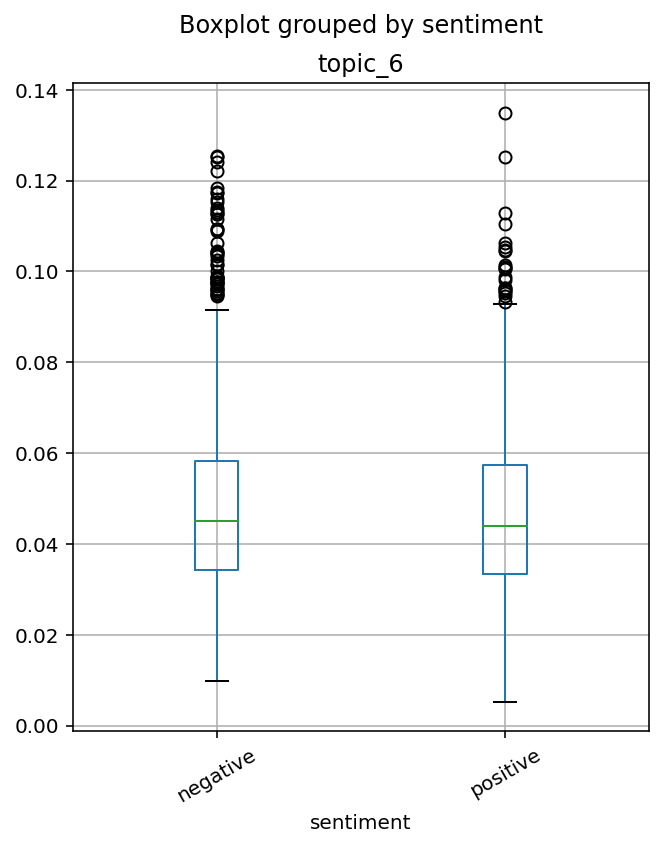

In [74]:
topic_6_viz = doc_topic_matrix.loc[doc_topic_matrix['Primary_Topic'] == 'topic_6']
topic_6_viz.boxplot('topic_6','sentiment',rot = 30,figsize=(5,6))

<AxesSubplot:title={'center':'topic_7'}, xlabel='sentiment'>

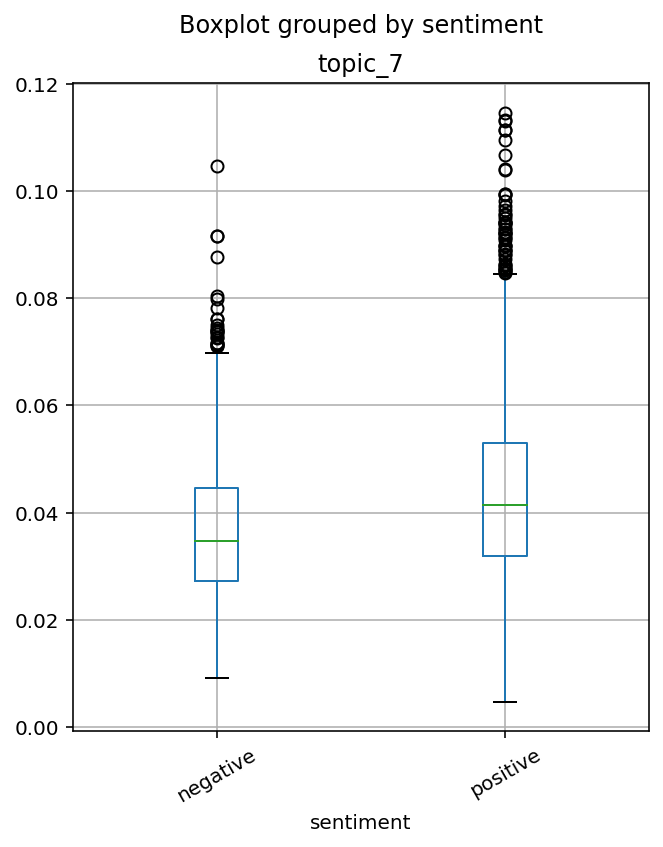

In [73]:
topic_7_viz = doc_topic_matrix.loc[doc_topic_matrix['Primary_Topic'] == 'topic_7']
topic_7_viz.boxplot('topic_7','sentiment',rot = 30,figsize=(5,6))

<AxesSubplot:title={'center':'topic_8'}, xlabel='sentiment'>

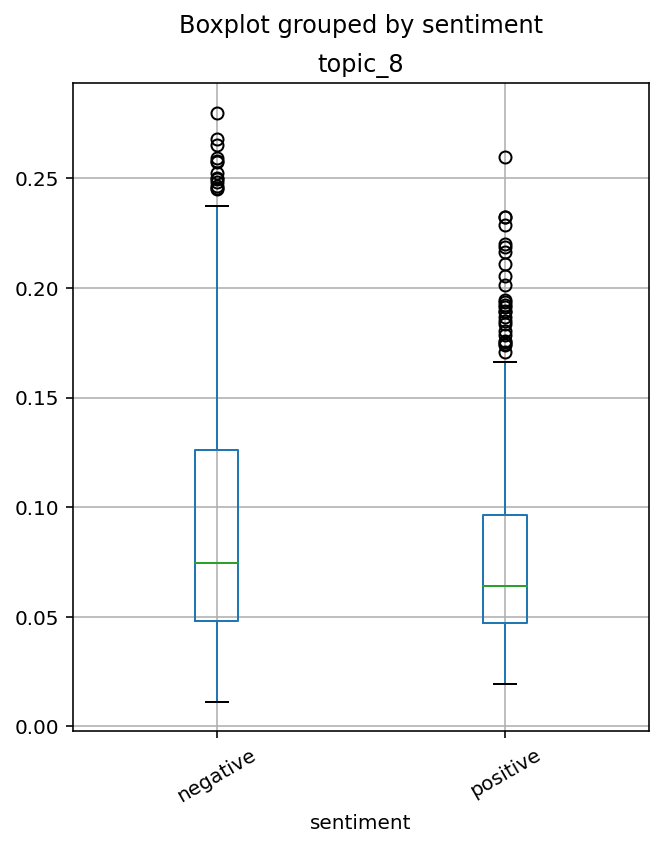

In [72]:
topic_8_viz = doc_topic_matrix.loc[doc_topic_matrix['Primary_Topic'] == 'topic_8']
topic_8_viz.boxplot('topic_8','sentiment',rot = 30,figsize=(5,6))

<AxesSubplot:title={'center':'topic_9'}, xlabel='sentiment'>

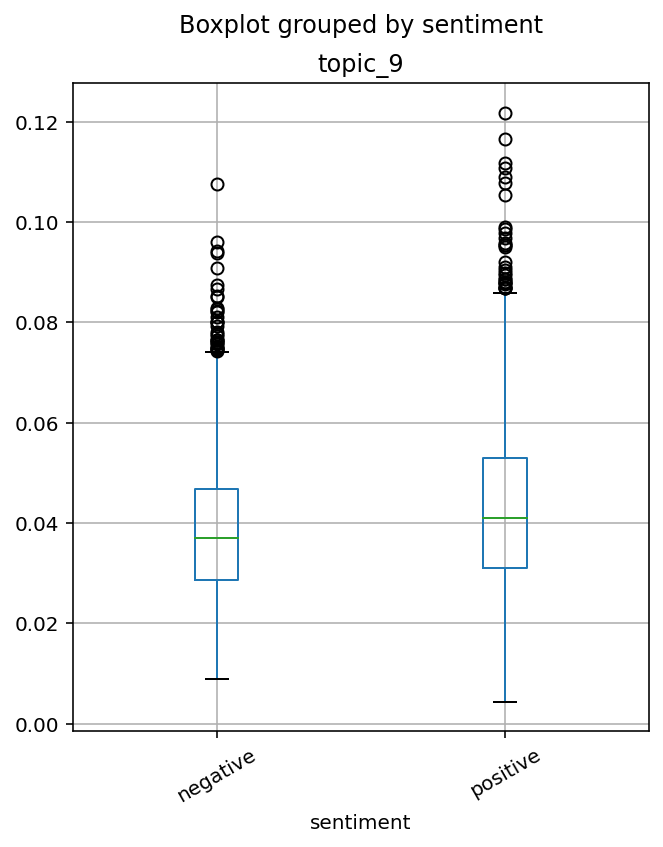

In [81]:
topic_9_viz = doc_topic_matrix.loc[doc_topic_matrix['Primary_Topic'] == 'topic_9']
topic_9_viz.boxplot('topic_9','sentiment',rot = 30,figsize=(5,6))

## Takeaways and Implications

The topics Romance, Drama and Acting Performance had a higher frequency in positive reviews than in negative reviews. Therefore, people tend to rate Romance and Drama por positively than other genres, in addition, when viewers are writing positive reviews they tend to talk about acting performance. 

After analyzing the words with highest expression in the Good Movie topic, we can say that viewers care for acting performance, and a plot with an interesting twist, when evaluating a movie as good. The same aspects where evident in the words with highest expression for the topic Bad Movie. Therefore, those are the two post important aspects of a movie for an audience to like or dislike a movie. 

Also, the audience tend to feel desapointed with film adaptations. Understanding the experience of the audience with the original text is vital to address their expectations as well as possible. Topic modeling on online movie reviews might inform book adaptation script writing. 

Finally, according to the words with highest expression in the topic romance, people care for the soundtrack in romantic movies, therefore it might be worth it to pay closer attention to the soundtrack for this genre. 